# 02 - Create predictive model for NYC Yellow Cab data set

In this notebook, you will

- Launch a [Coiled Cluster](cloud.coiled.io)
- Load a [Dask dataframe](https://tutorial.dask.org/04_dataframe.html) into your workspace
- partition data into training and testing sets
- perform a linear least square regression with 2 independent variables
- use [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html) to train a machine learning model

You will need

- Coiled
- Dask
- Dask-ML: a machine-learning library for Dask
- NumPy
- Matplotlib


## Launch a Coiled cluster

The first step is to spin up a Dask Cluster. In Coiled, this is done by creating a `coiled.Cluster` instance. You can use [keyword arguments](https://docs.coiled.io/user_guide/api.html#coiled.Cluster) to specify the details of your cluster further. Please read the [cluster creation documentation](https://docs.coiled.io/user_guide/cluster_creation.html) to know more.

Give a name to this cluster, if you don't specify this keyword argument, clusters will be given a unique randomly generated name.

In [1]:
import coiled

The predictive analysis will use [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html), so you can create a Coiled software environment using the following command in iPython or Jupyter. 

```python
import coiled
coiled.create_software_environment(
   name="xgboost-on-coiled",
   conda={
      "channels": [
        "conda-forge"
      ],
      "dependencies": [
        "coiled",
        "dask-ml",
        "dask>=2.23.0",
        "fastparquet",
        "pandas>=1.1.0",
        "python-snappy",
        "s3fs",
        "scikit-learn",
        "xgboost>=1.3.0"
      ]
    }
)
```

This creates a container with xgboost and a few other dependencies. You can open the cluster with your new software environment with the `coiled.Cluster` command and specify `software = <username>/xgboost-on-coiled`. Now, you can define the client to access the cluster. 

In [2]:
# cluster = coiled.Cluster(name="taxi-predict", n_workers=10)
from dask.distributed import Client
cluster = coiled.Cluster(n_workers=10, software='cooperrc/xgboost-on-coiled')

client = Client(cluster)

Output()

Found software environment build


/home/ryan/.conda/envs/coiledcloud/lib/python3.9/site-packages/coiled/cluster.py:629: UserWarning: Unable to locate credentials
  warnings.warn(str(e))


Once the cluster is created (you can see the status on your [Coiled dashboard](https://cloud.coiled.io/)), you can connect Dask to the cluster by creating a `distributed.Client` instance.

In [4]:
client

Client Scheduler: tls://ec2-100-26-42-77.compute-1.amazonaws.com:8786 Dashboard: http://ec2-100-26-42-77.compute-1.amazonaws.com:8787,Cluster Workers: 10 Cores: 20 Memory: 80.00 GiB


## Create data predictions in the cloud - Linear Regression

Now that you have a cluster running and Dask connected to it, do some computations. This example will run the computations on about 84 million rows. You will create a prediction in 3 steps:

1. create the Dask dataframe and select the independent variables
2. partition the data into testing and training sets
3. perform the linear regression using `mean()` and `compute()` 

### 1. Create the Dask dataframe

Here, you load the data into a Dask dataframe from AWS. 

In [5]:
import dask.dataframe as dd

taxi_full = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    dtype={
        "payment_type": "float64",
        "VendorID": "float64",
        "passenger_count": "float64",
        "RatecodeID": "float64",
    },
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

Now, you can remove the data that you found was unnecessary in the previous notebook, [01_Create descriptive statistics for NYC Yellow Cab data set](./Create descriptive statistics for NYC Yellow Cab data set). Save the variable as `taxi_full_wtips`. 

In [6]:
taxi_full_wtips = taxi_full[(taxi_full['tip_amount'] > 0) & 
                            (taxi_full['fare_amount'] > 0) & 
                            (taxi_full['trip_distance'] > 0)].persist()

### 2. Partition the data into testing and training sets

Load the `model_selection` library from Dask-ML. You will use this function to split the data into training and testing dataframes. The `X` variable holds all of the data except for `tip_amount`. The `y` variable is the `tip_amount`, your observations for predictions. 

In [42]:
import dask
from dask_ml.model_selection import train_test_split

X = taxi_full_wtips[['passenger_count', 
                            'trip_distance', 
                            'RatecodeID', 
                            'PULocationID', 
                            'DOLocationID', 
                            'payment_type', 
                            'fare_amount', 
                            'extra',  
                            'tolls_amount', 
                            'total_amount']]

y = taxi_full_wtips['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

In [43]:
X_train.columns

Index(['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'tolls_amount',
       'total_amount'],
      dtype='object')

In [44]:
x1, x2, y = X_train['fare_amount'], X_train['trip_distance'], y_train

x1, x2, y = dask.persist(x1, x2, y)

### 3. Perform the linear regression using `mean()` and `compute()` 

Linear regression minimizes the sum of squares error between a linear function of  dependent variables, 

$f(x_1,~x_2) = \beta + \alpha_1 x_1 + \alpha_2 x_2$

$\min(\sum|y - f(x_1,~x_2)|^2)$

where
- $\beta = offset$
- $x_1 = fare~amount$
- $x_2 = trip~distance$
- $y_1 = tip~amount$

These equations reduce to a single linear algebra equation as such

$\mathbf{Z}^T\mathbf{Z a} = \mathbf{Z}^T\mathbf{y}$

$\left[\begin{array}
~1 & \sum x_1/N & \sum x_2/N \\
\sum x_1/N & \sum x_1^2/N & \sum x_1x_2/N \\
\sum x_2/N &\sum x_1 x_2/N & ~\sum x_2^2/N \end{array}\right]$ = $
\left[\begin{array}
\sum y/N\\
\sum x_1 y/N\\
\sum x_2 y/N\\
\end{array}\right]$

You can use the `mean().compute()` command to calculate this matrix-vector equation. The result is a $3 \times 3$ array, `ZTZ`, and a vector of length 3, `ZTy`. 




In [10]:
Sx1 = x1.mean().compute()
Sx2 = x2.mean().compute()

In [11]:
Sx1x2 = (x1*x2).mean().compute()
Sx1x1 = (x1**2).mean().compute()
Sx2x2 = (x2**2).mean().compute()

In [12]:
import numpy as np
ZTZ = np.array([[1, Sx1, Sx2], 
                [Sx1, Sx1x1, Sx1x2],
                [Sx2, Sx1x2, Sx2x2]])

In [13]:
Sy = y.mean().compute()
Sx1y = (x1*y).mean().compute()
Sx2y = (x2*y).mean().compute()


Now, you have the calculated each array value. You can solve the linear least square problem and calculate $[\beta,~\alpha_1,~\alpha_2]$. 

In [14]:
ZTy = np.array([Sy, Sx1y, Sx2y])

A = np.linalg.solve(ZTZ, ZTy)
A

array([0.6119274 , 0.176382  , 0.07317207])

The result is that the predicted tip from this data set is:

$tip = \$0.61 + 0.18\cdot (\$total~fare) + 0.07\frac{\$}{mi}(trip~distance [mi])$

You can use the subset of data from [0 - Exploring the NYC Yellow taxi data set](./00_explore-taxi.ipynb) to visually inspect the model. 

Import Matplotlib and Pandas. Then, apply the same filter to the data to remove 0's. 

In [70]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
taxi_subset = pd.read_csv('./yellow_tripdata_2019-01_0-end-by-1000.csv')
taxi_subset = taxi_subset[(taxi_subset['tip_amount'] > 0) & 
                        (taxi_subset['fare_amount'] > 0) & 
                        (taxi_subset['trip_distance'] > 0)]

Now, you can apply your data to the `taxi_subset` dataframe. You can directly plug in the equation from above as such 

`predicted_tip = A[0]+A[1]*taxi_subset['fare_amount']+A[2]*taxi_subset['trip_distance']`

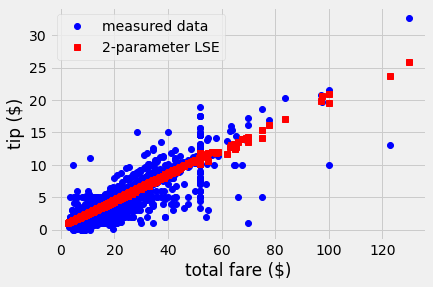

In [75]:
plt.plot(taxi_subset['fare_amount'], taxi_subset['tip_amount'], 
         'bo', 
        label = 'measured data')
plt.plot(taxi_subset['fare_amount'], 
         A[0]+A[1]*taxi_subset['fare_amount']+A[2]*taxi_subset['trip_distance'], 
         'rs', label = '2-parameter LSE')
plt.legend()
plt.xlabel('total fare ($)')
plt.ylabel('tip ($)');

### Mean squared error in 2-parameter model

The model captures the overall trend between tips and fare amounts, but there is variation that was not captured by the model. Here, calculate the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) to quantify the variance not captured by the current model

$MSE = \frac{\sum_1^N (y_{test} - y_{predict})^2}{N} = \frac{\sum_1^N (y_{test} - \$0.61 - 0.18\cdot (\$total~fare) - 0.07\frac{\$}{mi}(trip~distance [mi]))^2}{N}$

In [47]:
MSE = (1/len(y_test)*(y_test - A[0] - A[1]*X_test['fare_amount'] - A[2]*X_test['trip_distance'])**2).sum().compute()
MSE

2.503489841743055

## Improving the model by including more measurements

The current regression model only uses fare amount and trip distance to predict the taxi driver tip per trip. You can reduce the mean squared error (MSE) by including more measurements e.g. 

- `VendorID`: A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- `tpep_pickup_datetime`: The date and time when the meter was engaged.
- `tpep_dropoff_datetime`: The date and time when the meter was disengaged.
- `Passenger_count`: The number of passengers in the vehicle.
This is a driver-entered value.
- `Trip_distance`: The elapsed trip distance in miles reported by the taximeter.
- `PULocationID`: TLC Taxi Zone in which the taximeter was engaged
- `DOLocationID`: TLC Taxi Zone in which the taximeter was disengaged
- `RateCodeID`: The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
- `Payment_type`: A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
- `Fare_amount`: The time-and-distance fare calculated by the meter.
Extra Miscellaneous extras and surcharges. Currently, this only includes
the $\$0.50$ and $\$1$ rush hour and overnight charges.
- `Tolls_amount`: Total amount of all tolls paid in trip.
- `Total_amount`: The total amount charged to passengers. Does not include cash tips.

Here, you will use [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) to complete a regression analysis. 
1. train the model with the training data set
2. plot the predicted response on the subset of data
3. calculate the mean squared error for XGBoost test data



In [49]:
import xgboost as xgb
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)

### 1. Train the model

Here, you use the Coiled `client` to train the model using 12 measurements described above. The `output` variable is the result of the [`xgboost.dask.train`](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html#other-customization). Here, you will build a model with
- regression and squared error loss `reg:squarederror`
- the maximum tree depth of 6 `'max_depth': 6`
- categorical data enabled `'enable_categorical': True`
- 10 boosting rounds `num_boost_round=10`
- training data set to `X_train` and `y_train` contained in the `dtrain` variable

In [77]:
output = xgb.dask.train(
    client=client,
    params={
        'objective': 'reg:squarederror',
        'max_depth': 10,
        'enable_categorical': True
    },
    dtrain=dtrain,
    num_boost_round=10
#     evals=[(dtrain, 'train')]
)

### 2. Plot the predicted tips on a subset

Now, the model has been trained with XGBoost. You can use the `taxi_subset` imported from `yellow_tripdata_2019-01_0-end-by-1000.csv` to plot a subset of the data. 

- convert the Pandas dataframe to a Dask dataframe with `dask.dataframe.from_pandas`
- build the XGBoost Dask Matrix as above for the training data with `xgb.dask.DaskMatrix`

In [80]:
from dask import dataframe as dd
X_subset = dd.from_pandas(taxi_subset[['passenger_count', 
                            'trip_distance', 
                            'RatecodeID', 
                            'PULocationID', 
                            'DOLocationID', 
                            'payment_type', 
                            'fare_amount', 
                            'extra',  
                            'tolls_amount', 
                            'total_amount']], npartitions = 1)
y_subset = dd.from_pandas(taxi_subset['tip_amount'], npartitions = 1)
dsubset = xgb.dask.DaskDMatrix(client, X_subset, y_subset)

Now, you can use the Dask dataframe as input for the regression model using the `xgb.dask.predict` as such

In [81]:
y_subset_predict = xgb.dask.predict(client, output['booster'], dsubset)

Finally, you can plot the results. Here, you can compare the 2-parameter regression model to the 12-parameter XGBoost model. You capture much more of the variation in the tips with the new model

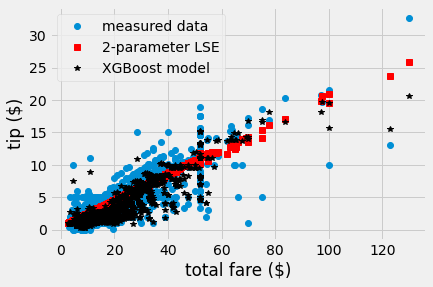

In [82]:
plt.plot(X_subset['fare_amount'].compute(), y_subset.compute(), 
         'o', 
        label = 'measured data')
plt.plot(taxi_subset['fare_amount'], 
         A[0]+A[1]*taxi_subset['fare_amount']+A[2]*taxi_subset['trip_distance'], 
         'rs', label = '2-parameter LSE')
plt.plot(X_subset['fare_amount'].compute(), y_subset_predict.compute(), 
         'k*', label = 'XGBoost model')
plt.legend()
plt.xlabel('total fare ($)')
plt.ylabel('tip ($)');


### 3. Calculate the MSE for the XGBoost model 

The 2-parameter LSE model had $MSE = (\$)^2 2.5$. The 12-parameter XGBoost model should reduce this MSE. First, use the booster model to predict the tips using `xgb.dask.predict` on the `X_test` data. Then, compute the average `sum()` of the squared errors. 

In [83]:
prediction = xgb.dask.predict(client, output['booster'], X_test)
MSE_w_xgb = (1/len(prediction)*(prediction - y_test)**2).sum().compute()

In [84]:
MSE_w_xgb

1.910368403467699

You reduced the MSE from $(\$)^2 2.50\rightarrow(\$)^2 1.91$, congratulations! There are many other factors that can play an important role in the tips, but you built a model that can use the NYC Yellow Cab taxi data set to predict driver tips using distances, fares, passenger count, pickup and dropoff IDs, and toll amounts. You can play with the parameters to reduce the error in the test data

## Wrapping up

In this notebook, you created a prediction for taxi driver tips based upon over 84 million taxi rides in NYC. You 

- loaded the NYC Yellow Cab data set into Dask dataframe on a Coiled cluster
- created a 2-parameter least squares error model using some `compute()` commands and linear algebra
- created a 12-parameter XGBoost squared error regression model 
- reduced the mean squared error (MSE) going from 2-parameters to 12-parameters
- plotted subsets of the NYC Yellow Cab taxi data set and the model predictions


Next steps: go try Coiled and build some new models or try new data!

In [58]:

coiled.delete_cluster(name="taxi-predict")
client.close()

Cluster deleted successfully.